# HSSM Tutorial

This notebook demonstrates how to use the HSSM class to create hierarchical models. The tutorial will be based on simulated data from the [SSM Simulators (SSMS)](https://github.com/AlexanderFengler/ssms) package.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true, sv_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, sv_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,0.779000,1.0
1,4.325905,1.0
2,0.991997,1.0
3,8.095633,1.0
4,6.713732,1.0
...,...,...
995,6.176771,1.0
996,3.077996,1.0
997,3.789944,1.0
998,3.458968,1.0


## The simplest case
### DDM using the analytical likelihood function from Navarro & Fuss (2009)

#### Analytical model 

In [3]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt, response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)
sv ~ Uniform(lower: 0.0, upper: 1.2000000476837158)
a ~ Uniform(lower: 0.5, upper: 2.009999990463257)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
t ~ Uniform(lower: 0.0, upper: 2.009999990463257)

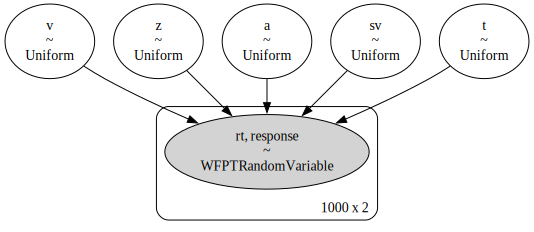

In [4]:
simple_ddm_model.graph()

In [9]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sv, t, a, v]
INFO:pymc:NUTS: [z, sv, t, a, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

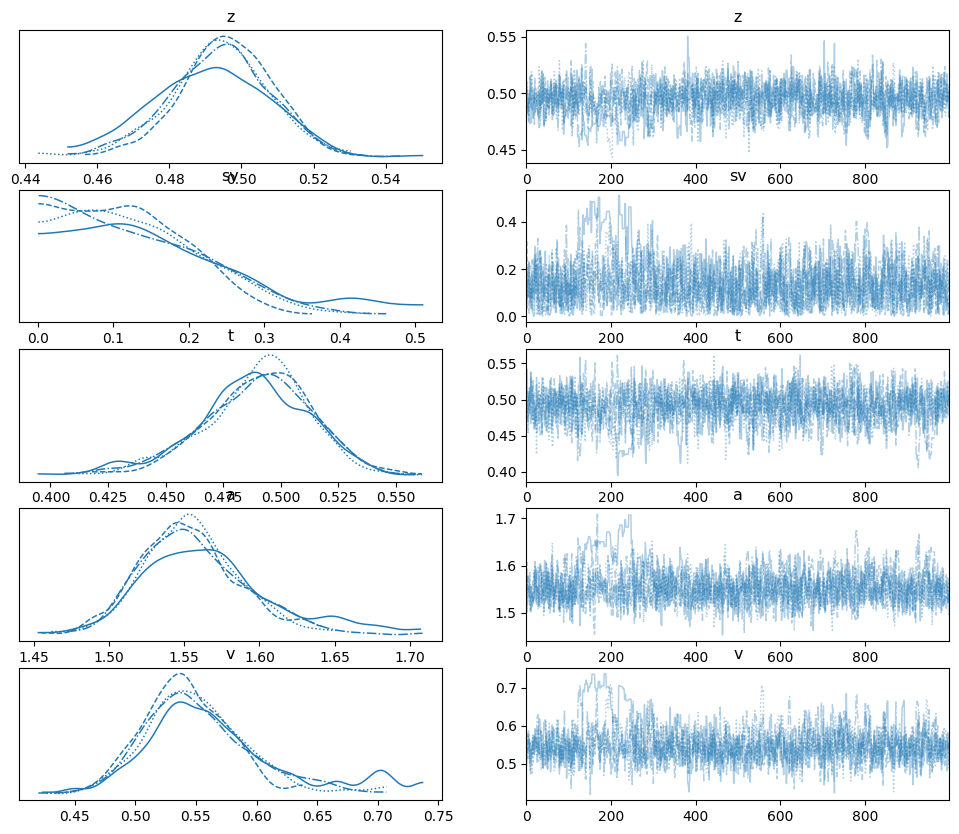

In [10]:
az.plot_trace(simple_ddm_model.trace);

In [11]:
az.summary(simple_ddm_model.trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.494,0.014,0.467,0.521,0.001,0.001,400.0,558.0,1.02
sv,0.139,0.097,0.000,0.301,0.009,0.008,157.0,87.0,1.03
t,0.489,0.024,0.441,0.531,0.001,0.001,588.0,347.0,1.01
a,1.558,0.037,1.490,1.627,0.003,0.002,201.0,77.0,1.03
v,0.552,0.047,0.467,0.642,0.005,0.004,166.0,77.0,1.03


## One step up: An angle model using an approximation network

#### Simulating Angle Data

In [12]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
dataset_lan = pd.DataFrame(obs_angle, columns=["rt", "response"])
dataset_lan

,rt,response
0,1.536992,1.0
1,1.395992,1.0
2,1.358993,1.0
3,2.010015,1.0
4,1.531992,1.0
...,...,...
995,2.309029,-1.0
996,1.458991,1.0
997,1.055996,1.0
998,2.895009,1.0


In [13]:
angle_model = hssm.HSSM(data=dataset_lan, model="angle")
angle_model

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt, response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)
a ~ Uniform(lower: 0.0, upper: 1.2000000476837158)
z ~ Uniform(lower: 0.0, upper: 2.009999990463257)
t ~ Uniform(lower: 0.0, upper: 0.8999999761581421)
theta ~ Uniform(lower: 0.0, upper: 2.009999990463257)

In [14]:
pytensor.config.floatX = "float32"

angle_model.sample(cores=1, draws=500, tune=500, mp_ctx="forkserver")

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc:Sequential sampling (2 chains in 1 job)
NUTS: [a, t, theta, z, v]
INFO:pymc:NUTS: [a, t, theta, z, v]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 44 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 44 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

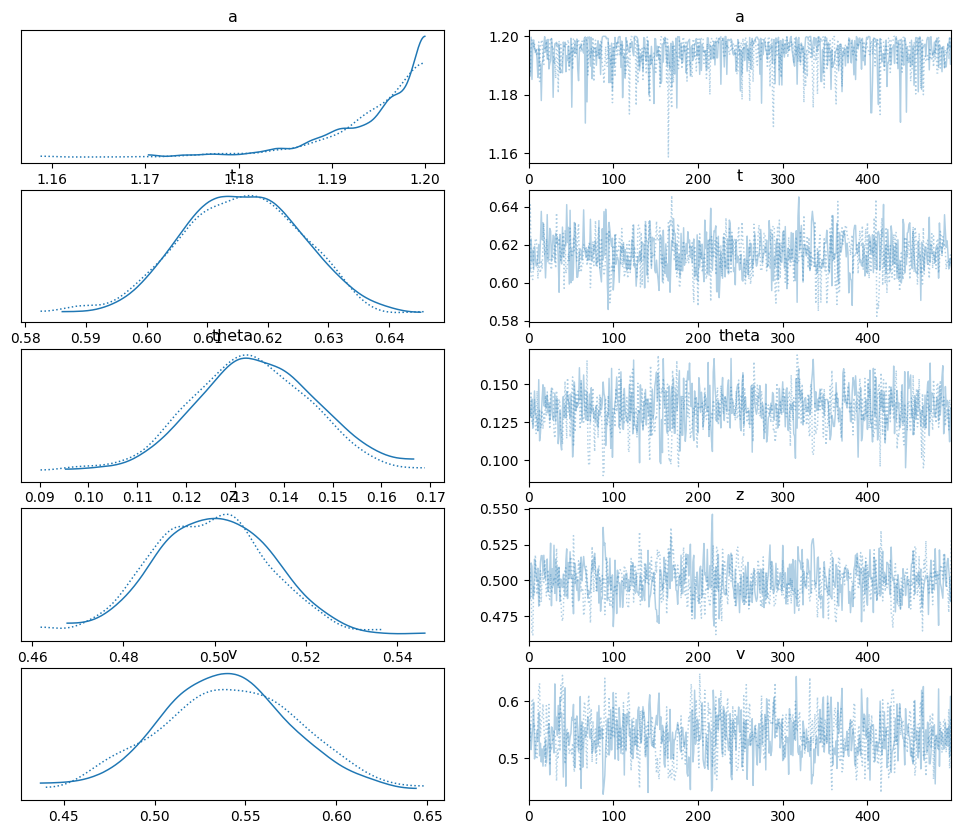

In [16]:
az.plot_trace(angle_model.trace);

#### Sampling the angle model using jax

In [17]:
from jax.config import config

config.update("jax_enable_x64", False)

angle_model.sample(sampler="nuts_numpyro")

/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:623: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.684087
Sampling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
sample: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 102.78it/s, 15 steps of size 4.47e-01. acc. prob=0.91]
/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for m

Sampling time =  0:01:19.254196
Transforming variables...
Transformation time =  0:00:00.069730


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [18]:
az.summary(angle_model.trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.194,0.006,1.183,1.200,0.000,0.000,2407.0,1598.0,1.0
t,0.616,0.010,0.597,0.636,0.000,0.000,2947.0,2958.0,1.0
theta,0.133,0.014,0.108,0.158,0.000,0.000,3130.0,2056.0,1.0
z,0.499,0.013,0.475,0.523,0.000,0.000,2437.0,2425.0,1.0
v,0.541,0.040,0.469,0.620,0.001,0.001,2183.0,2491.0,1.0


### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [19]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.5, 0.2, size=1000)
y = np.random.uniform(0.4, 0.1, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [20]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [21]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,1.526992,1,0.378584,0.377298
1,1.679999,1,0.338506,0.264398
2,1.410992,1,0.344034,0.350076
3,2.691024,1,0.390513,0.160446
4,2.233025,-1,0.207207,0.159215
...,...,...,...,...
995,2.563033,1,0.483469,0.354620
996,2.500037,-1,0.207440,0.260733
997,1.292993,-1,0.377366,0.211116
998,1.963012,1,0.323497,0.292291


In [22]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt, response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
sv ~ Uniform(lower: 0.0, upper: 1.2000000476837158)
a ~ Uniform(lower: 0.5, upper: 2.009999990463257)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
t ~ Uniform(lower: 0.0, upper: 2.009999990463257)

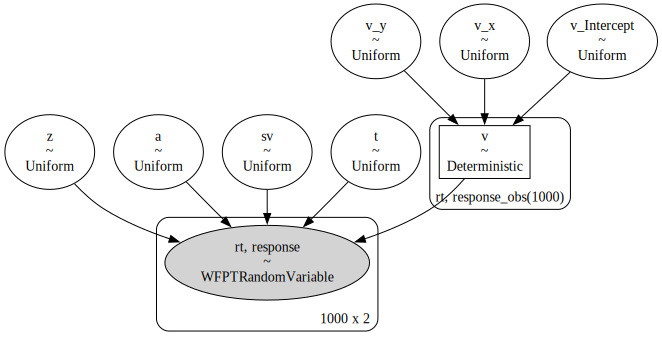

In [23]:
model_reg_v.graph()

In [24]:
trace_reg_v = model_reg_v.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sv, t, a, v_Intercept, v_x, v_y]
INFO:pymc:NUTS: [z, sv, t, a, v_Intercept, v_x, v_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


array([[<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'v_Intercept'}>,
        <AxesSubplot: title={'center': 'v_Intercept'}>],
       [<AxesSubplot: title={'center': 'v_x'}>,
        <AxesSubplot: title={'center': 'v_x'}>],
       [<AxesSubplot: title={'center': 'v_y'}>,
        <AxesSubplot: title={'center': 'v_y'}>]], dtype=object)

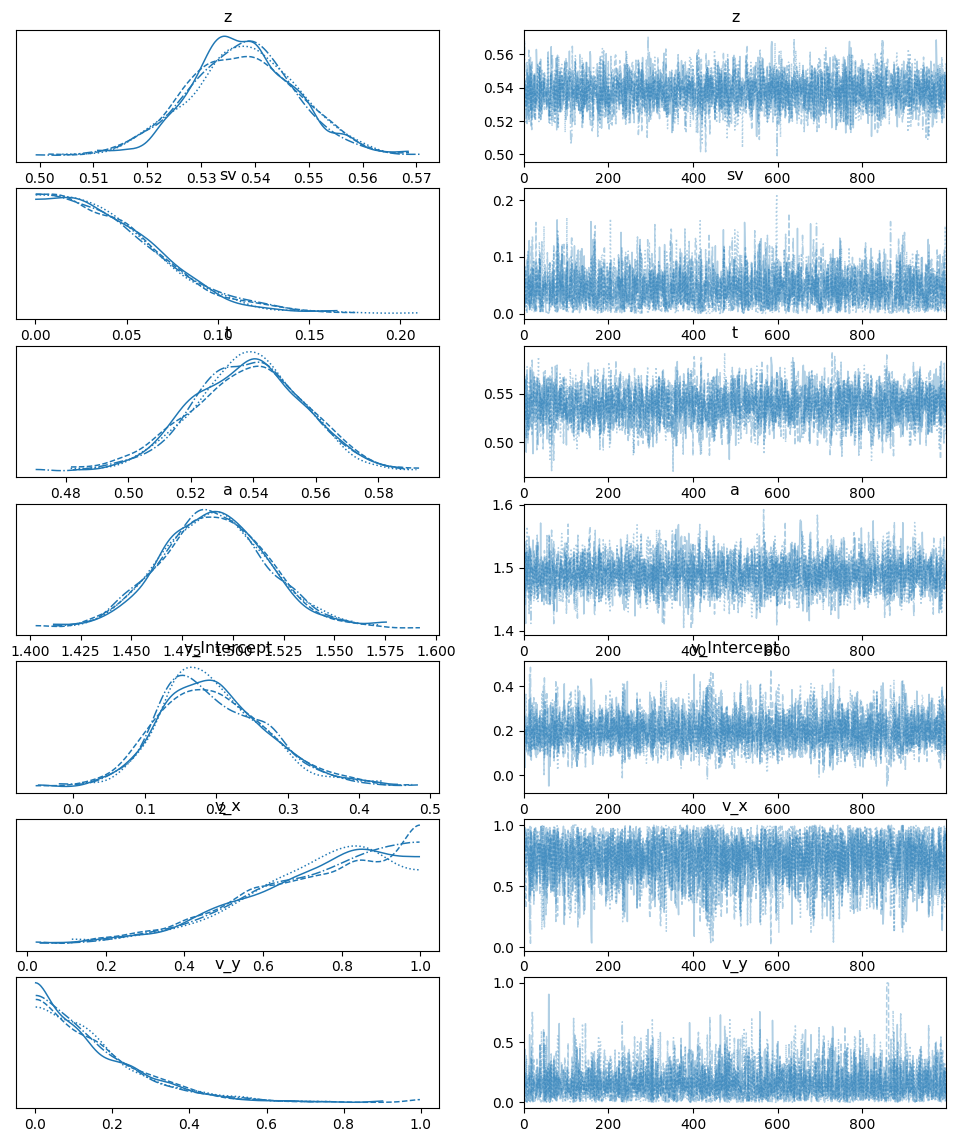

In [25]:
az.plot_trace(model_reg_v.trace)

In [26]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.538,0.010,0.518,0.556,0.000,0.000,3805.0,2776.0,1.0
sv,0.042,0.031,0.000,0.097,0.001,0.000,2532.0,1204.0,1.0
t,0.538,0.018,0.504,0.570,0.000,0.000,3326.0,2864.0,1.0
a,1.491,0.026,1.440,1.539,0.000,0.000,3660.0,2549.0,1.0
v_Intercept,0.197,0.075,0.067,0.344,0.001,0.001,3972.0,2430.0,1.0
v_x,0.730,0.191,0.400,1.000,0.003,0.002,3497.0,1408.0,1.0
v_y,0.157,0.136,0.000,0.402,0.002,0.002,3718.0,1991.0,1.0


#### Case 2: adding initval to priors along with lower and upper.

In [ ]:
hssm_include_val = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1.0,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [ ]:
hssm_include_val.params

In [ ]:
samples_two = hssm_include_val.sample()

In [ ]:
az.summary(samples_two)

#### Case 3: not specifying parent v in the include parameter. 

In [ ]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [ ]:
hssm_include_val

In [ ]:
hssm_include_val.graph()

In [ ]:
samples_three = hssm_include_val.sample(draws=200, tune=200)

#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [ ]:
hssm_include_list.model

In [ ]:
hssm_include_list.graph()

In [ ]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

In [ ]:
samples_three = hssm_include_list.sample(draws=100, tune=100)